<a href="https://www.kaggle.com/code/castle451/weather-recruit-forecast-work-r2?scriptVersionId=103927247" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# データの読み込み

In [368]:
# ライブラリのインポート
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)

import xgboost as xgb

# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)



In [432]:
# air_reserve
df_ar = pd.read_csv('/kaggle/input/air-base-data/air_reserve.csv')
# air_store_info
df_as = pd.read_csv('/kaggle/input/air-base-data/air_store_info.csv')
# air_visit_data
df_av = pd.read_csv('/kaggle/input/air-base-data/air_visit_data.csv')
# air_store_info_with_nearest_active_station
df_nearest_active_station = pd.read_csv('/kaggle/input/rrv-weather-data/air_store_info_with_nearest_active_station.csv')

# preped-tokyo-tokyokana-tonokyo
df_weather_info = pd.read_csv('../input/weather-info-target-station/tokyo__tokyo-kana__tonokyo.csv')


In [ ]:
print(df_weather_info.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df_weather_info) # df.head()に同じ(文中に入れるときはdisplay()を使う)

In [370]:
print(df_as.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df_as) # df.head()に同じ(文中に入れるときはdisplay()を使う)

(829, 5)


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [ ]:
print(df_nearest_active_station.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df_nearest_active_station) # df.head()に同じ(文中に入れるときはdisplay()を使う)

In [371]:
# データの確認
print(df_ar.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df_ar) # df.head()に同じ(文中に入れるときはdisplay()を使う)

(92378, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [218]:
print(df_av.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df_av) # df.head()に同じ(文中に入れるときはdisplay()を使う)

(252108, 3)


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


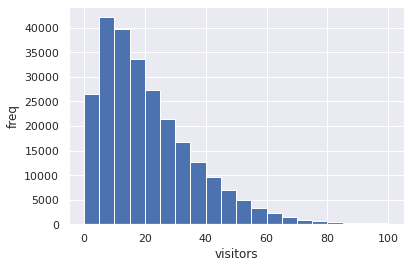

In [433]:
data = df_av['visitors'].tolist()
plt.xlabel('visitors')
plt.ylabel('freq')
plt.hist(data, range=(0, 100), bins=20);


# 前処理：変数作成
※今回は、XGBoostベースのアルゴリズムのため、変数は全て数値化する

In [434]:
df_av['visit_date_ymd'] = pd.to_datetime(df_av['visit_date'])
df_av['last_week_day'] = df_av['visit_date_ymd'] - datetime.timedelta(days=7)
df_av.head()


,air_store_id,visit_date,visitors,visit_date_ymd,last_week_day
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,2016-01-06
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,2016-01-07
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,2016-01-08
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,2016-01-09
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,2016-01-11


In [435]:
df_av_last_week = df_av.loc[:,['visit_date_ymd','air_store_id','visitors']]
df_av_last_week.rename(columns={'visitors': 'last_week_visitors'}, inplace=True)
df_av_last_week.rename(columns={'visit_date_ymd': 'last_week_day'}, inplace=True)
df_av_last_week.head()

,last_week_day,air_store_id,last_week_visitors
0,2016-01-13,air_ba937bf13d40fb24,25
1,2016-01-14,air_ba937bf13d40fb24,32
2,2016-01-15,air_ba937bf13d40fb24,29
3,2016-01-16,air_ba937bf13d40fb24,22
4,2016-01-18,air_ba937bf13d40fb24,6


In [436]:
df_av_tmp = pd.merge(df_av, df_av_last_week, on=['air_store_id','last_week_day'],how='left')

df_av = df_av_tmp.drop(['visit_date_ymd','last_week_day'] ,axis=1)
df_av.head(20) 

,air_store_id,visit_date,visitors,last_week_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,NaN
5,air_ba937bf13d40fb24,2016-01-19,9,NaN
6,air_ba937bf13d40fb24,2016-01-20,31,25.0
7,air_ba937bf13d40fb24,2016-01-21,21,32.0
8,air_ba937bf13d40fb24,2016-01-22,18,29.0
9,air_ba937bf13d40fb24,2016-01-23,26,22.0


In [243]:
#df_ar['reserve_datetime_diff'] = (pd.to_datetime(df_ar['visit_datetime']) - pd.to_datetime(df_ar['reserve_datetime']) ).dt.days
#df_ar.head(20)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,0
5,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2,0
6,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 15:00:00,4,0
7,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-02 14:00:00,2,0
8,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-01 20:00:00,2,0
9,air_2b8b29ddfd35018e,2016-01-02 17:00:00,2016-01-02 17:00:00,2,0


In [437]:
# =============================================================================
# 日付
# =============================================================================
time_format = '%Y-%m-%d'
def seperate_date(data):     
    # split date feature in real visit datetime
    data_time = pd.to_datetime(data.target_date, format=time_format)
    data['Year_visit']= data_time.dt.year
    data['Month_visit'] = data_time.dt.month
    data['DayOfYear_visit'] = data_time.dt.dayofyear
    # data['DayOfMonth_visit'] = data_time.dt.day
#    data['WeekOfYear_visit'] = data_time.dt.week
    data['DayOfWeek_visit'] = data_time.dt.dayofweek
#    del data['visit_date']
    return data

In [438]:
df_ar.rename(columns={'visit_datetime': 'target_date'}, inplace=True)
seperate_date(df_ar)
display(df_ar.sort_values(['air_store_id','target_date']))

,air_store_id,target_date,reserve_datetime,reserve_visitors,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit
17963,air_00a91d42b08b08d9,2016-10-31 20:00:00,2016-10-31 16:00:00,2,2016,10,305,0
30808,air_00a91d42b08b08d9,2016-12-05 19:00:00,2016-12-01 15:00:00,9,2016,12,340,0
34613,air_00a91d42b08b08d9,2016-12-14 19:00:00,2016-12-08 10:00:00,18,2016,12,349,2
36458,air_00a91d42b08b08d9,2016-12-17 19:00:00,2016-12-11 16:00:00,2,2016,12,352,5
37992,air_00a91d42b08b08d9,2016-12-20 20:00:00,2016-12-18 17:00:00,4,2016,12,355,1


In [439]:
#予約データは1日あたり複数トランザクションデータの形式であるため、
#1日1レコードとするために集計
df_ar_grouped = df_ar.groupby(['air_store_id', 'Year_visit','Month_visit','DayOfYear_visit','DayOfWeek_visit'],as_index=False).sum()
df_ar_grouped.head()


,air_store_id,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit,reserve_visitors
0,air_00a91d42b08b08d9,2016,10,305,0,2
1,air_00a91d42b08b08d9,2016,12,340,0,9
2,air_00a91d42b08b08d9,2016,12,349,2,18
3,air_00a91d42b08b08d9,2016,12,352,5,2
4,air_00a91d42b08b08d9,2016,12,355,1,4


In [440]:
df_nearest_active_station_as = pd.merge(df_nearest_active_station, df_as, on='air_store_id',how='inner')
display(df_nearest_active_station_as) 


,air_store_id,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,air_genre_name_y,air_area_name_y,latitude_y,longitude_y
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [441]:
df_taget_store = df_nearest_active_station_as.query('station_id.str.contains("tonoky")', engine='python')
display(df_taget_store) 


,air_store_id,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,air_genre_name_y,air_area_name_y,latitude_y,longitude_y
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
5,air_99c3eae84130c1cb,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
6,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
7,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
8,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [442]:
# 本分析では、station「tokyo__tokyo-kana__tonokyo」が最寄りのストアを対象に、分析する 
df_target_ar_as = pd.merge(df_ar_grouped, df_taget_store, on='air_store_id',how='inner')
display(df_target_ar_as) 

,air_store_id,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit,reserve_visitors,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,...,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,air_genre_name_y,air_area_name_y,latitude_y,longitude_y
0,air_00a91d42b08b08d9,2016,10,305,0,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,"""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,2016,12,340,0,9,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,"""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,2016,12,349,2,18,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,"""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,2016,12,352,5,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,"""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,2016,12,355,1,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,"""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [443]:
df_av.rename(columns={'visit_date': 'target_date'}, inplace=True)
seperate_date(df_av)
display(df_av.sort_values(['air_store_id','target_date']))

,air_store_id,target_date,visitors,last_week_visitors,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit
87534,air_00a91d42b08b08d9,2016-07-01,35,NaN,2016,7,183,4
87535,air_00a91d42b08b08d9,2016-07-02,9,NaN,2016,7,184,5
87536,air_00a91d42b08b08d9,2016-07-04,20,NaN,2016,7,186,0
87537,air_00a91d42b08b08d9,2016-07-05,25,NaN,2016,7,187,1
87538,air_00a91d42b08b08d9,2016-07-06,29,NaN,2016,7,188,2


In [444]:
#天気情報を追加
df_weather_info.rename(columns={'calendar_date': 'target_date'}, inplace=True)
seperate_date(df_weather_info)
display(df_weather_info)


,target_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit
0,2016-01-01,7.5,12.1,3.6,NaN,9.0,11.80,NaN,NaN,2.6,4.5,1022.4,45.0,1025.4,2.5,2016,1,1,4
1,2016-01-02,7.3,13.4,2.6,NaN,7.5,11.59,NaN,NaN,1.9,5.2,1018.6,51.0,1021.5,4.3,2016,1,2,5
2,2016-01-03,9.3,16.2,3.0,NaN,8.3,10.77,NaN,NaN,1.4,7.0,1013.2,61.0,1016.2,5.3,2016,1,3,6
3,2016-01-04,9.2,15.2,4.4,NaN,8.9,11.19,NaN,NaN,1.6,6.8,1010.4,60.0,1013.3,0.0,2016,1,4,0
4,2016-01-05,10.9,15.4,5.1,NaN,8.4,10.57,NaN,NaN,1.8,6.5,1013.1,51.0,1016.0,2.8,2016,1,5,1


In [445]:
df_target_ar_as_wf = pd.merge(df_target_ar_as, df_weather_info, on=['Year_visit','Month_visit','DayOfYear_visit'],how='inner')
display(df_target_ar_as_wf) 

,air_store_id,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit_x,reserve_visitors,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,...,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,DayOfWeek_visit_y
0,air_00a91d42b08b08d9,2016,10,305,0,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,9.79,NaN,NaN,1.8,11.0,1021.2,68.0,1024.1,9.0,0
1,air_12c4fb7a423df20d,2016,10,305,0,4,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,9.79,NaN,NaN,1.8,11.0,1021.2,68.0,1024.1,9.0,0
2,air_28064154614b2e6c,2016,10,305,0,6,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,...,9.79,NaN,NaN,1.8,11.0,1021.2,68.0,1024.1,9.0,0
3,air_290e7a57b390f78e,2016,10,305,0,7,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,9.79,NaN,NaN,1.8,11.0,1021.2,68.0,1024.1,9.0,0
4,air_2cee51fa6fdf6c0d,2016,10,305,0,7,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,9.79,NaN,NaN,1.8,11.0,1021.2,68.0,1024.1,9.0,0


In [446]:
df_target_ar_as_av_wf = pd.merge(df_target_ar_as_wf, df_av, on=['air_store_id','Year_visit','Month_visit','DayOfYear_visit'],how='inner')
display(df_target_ar_as_av_wf) 

,air_store_id,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit_x,reserve_visitors,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,...,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,DayOfWeek_visit_y,target_date_y,visitors,last_week_visitors,DayOfWeek_visit
0,air_00a91d42b08b08d9,2016,10,305,0,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,11.0,1021.2,68.0,1024.1,9.0,0,2016-10-31,26,1.0,0
1,air_12c4fb7a423df20d,2016,10,305,0,4,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,11.0,1021.2,68.0,1024.1,9.0,0,2016-10-31,16,17.0,0
2,air_28064154614b2e6c,2016,10,305,0,6,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,...,11.0,1021.2,68.0,1024.1,9.0,0,2016-10-31,11,13.0,0
3,air_290e7a57b390f78e,2016,10,305,0,7,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,11.0,1021.2,68.0,1024.1,9.0,0,2016-10-31,11,NaN,0
4,air_2cee51fa6fdf6c0d,2016,10,305,0,7,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,11.0,1021.2,68.0,1024.1,9.0,0,2016-10-31,12,NaN,0


# 前処理:ラベルエンコード

※使うアルゴリズムはXGBoostベースのため、ワンホットエンコーディングの必要はなし

In [447]:
# =============================================================================
# label encoding
# =============================================================================
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

le.fit(df_target_ar_as_av_wf['air_genre_name_x'])
df_target_ar_as_av_wf['air_genre_name_label'] = le.transform(df_target_ar_as_av_wf['air_genre_name_x'])

display(df_target_ar_as_av_wf)

,air_store_id,Year_visit,Month_visit,DayOfYear_visit,DayOfWeek_visit_x,reserve_visitors,air_genre_name_x,air_area_name_x,latitude_x,longitude_x,...,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,DayOfWeek_visit_y,target_date_y,visitors,last_week_visitors,DayOfWeek_visit,air_genre_name_label
0,air_00a91d42b08b08d9,2016,10,305,0,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,...,1021.2,68.0,1024.1,9.0,0,2016-10-31,26,1.0,0,6
1,air_12c4fb7a423df20d,2016,10,305,0,4,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,1021.2,68.0,1024.1,9.0,0,2016-10-31,16,17.0,0,10
2,air_28064154614b2e6c,2016,10,305,0,6,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,...,1021.2,68.0,1024.1,9.0,0,2016-10-31,11,13.0,0,7
3,air_290e7a57b390f78e,2016,10,305,0,7,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,1021.2,68.0,1024.1,9.0,0,2016-10-31,11,NaN,0,6
4,air_2cee51fa6fdf6c0d,2016,10,305,0,7,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,1021.2,68.0,1024.1,9.0,0,2016-10-31,12,NaN,0,10


# 天気情報なしの場合
まずは天気情報なしのモデルをつくってみる

# データチェック：欠損値確認

In [450]:
print(df_target_ar_as_av_wf.isnull().sum())

air_store_id               0
Year_visit                 0
Month_visit                0
DayOfYear_visit            0
DayOfWeek_visit_x          0
reserve_visitors           0
air_genre_name_x           0
air_area_name_x            0
latitude_x                 0
longitude_x                0
latitude_str               0
longitude_str              0
station_id                 0
station_latitude           0
station_longitude          0
station_vincenty           0
station_great_circle       0
air_genre_name_y           0
air_area_name_y            0
latitude_y                 0
longitude_y                0
target_date_x              0
avg_temperature            0
high_temperature           0
low_temperature            0
precipitation           4417
hours_sunlight             0
solar_radiation            0
deepest_snowfall        7983
total_snowfall          8045
avg_wind_speed             0
avg_vapor_pressure         2
avg_local_pressure         0
avg_humidity               2
avg_sea_pressu

In [451]:
print(df_target_ar_as_av_wf.describe())

        Year_visit  Month_visit  DayOfYear_visit  DayOfWeek_visit_x  \
count  8052.000000  8052.000000      8052.000000        8052.000000   
mean   2016.493915     5.432191       150.477521           2.958644   
std       0.499994     4.217712       129.104631           1.822833   
min    2016.000000     1.000000         1.000000           0.000000   
25%    2016.000000     2.000000        49.000000           1.000000   
50%    2016.000000     3.000000        90.000000           3.000000   
75%    2017.000000    11.000000       316.000000           4.000000   
max    2017.000000    12.000000       366.000000           6.000000   

       reserve_visitors   latitude_x  longitude_x  station_latitude  \
count       8052.000000  8052.000000  8052.000000      8.052000e+03   
mean          11.356309    35.678069   139.737488      3.569167e+01   
std           11.194561     0.022313     0.034784      1.421174e-14   
min            1.000000    35.658068   139.685474      3.569167e+01   
25%  

In [ ]:
# precipitationの半数が欠損値であるあり、
# deepest_snowfall , total_snowfallは8割以上欠損値であり 
# 0/平均値はこの場合、意味をもつため、0置換・予測置換・予測置換　×
# そのため対応として、削除する

In [458]:
#重複、不要カラムの削除
dataset = df_target_ar_as_av_wf.drop(
    ["air_area_name_x","latitude_x","longitude_x","latitude_str","longitude_str","station_id","station_latitude","station_longitude","station_vincenty","station_great_circle","air_genre_name_y","air_area_name_y","latitude_y","longitude_y","air_store_id","target_date_x","air_genre_name_x","deepest_snowfall","total_snowfall","DayOfWeek_visit_x","target_date_y","DayOfWeek_visit_y","precipitation","deepest_snowfall","total_snowfall","avg_temperature","high_temperature","low_temperature","hours_sunlight","solar_radiation","avg_wind_speed","avg_vapor_pressure","avg_local_pressure","avg_humidity","avg_sea_pressure","cloud_cover"],axis=1)
display(dataset)


,Year_visit,Month_visit,DayOfYear_visit,reserve_visitors,visitors,last_week_visitors,DayOfWeek_visit,air_genre_name_label
0,2016,10,305,2,26,1.0,0,6
1,2016,10,305,4,16,17.0,0,10
2,2016,10,305,6,11,13.0,0,7
3,2016,10,305,7,11,NaN,0,6
4,2016,10,305,7,12,NaN,0,10


In [459]:
print(dataset.dtypes)

Year_visit                int64
Month_visit               int64
DayOfYear_visit           int64
reserve_visitors          int64
visitors                  int64
last_week_visitors      float64
DayOfWeek_visit           int64
air_genre_name_label      int64
dtype: object


# データチェック：相関

※今回利用するアルゴリズムはxgboostでるため、
scale調整、相関する変数の処理は自動的にやってくれるが、一応相関を確認

In [460]:
# Todo
# Let's look at correlation beween features and target
dataset.corr()['visitors']

Year_visit              0.042821
Month_visit             0.045871
DayOfYear_visit         0.048971
reserve_visitors        0.484013
visitors                1.000000
last_week_visitors      0.725301
DayOfWeek_visit         0.196785
air_genre_name_label   -0.027680
Name: visitors, dtype: float64

In [462]:
#corr = dataset.drop(["Year_visit","Month_visit","DayOfYear_visit","DayOfWeek_visit"],axis=1).corr(method='pearson')
corr = dataset.corr(method='pearson')

In [463]:
corr

,Year_visit,Month_visit,DayOfYear_visit,reserve_visitors,visitors,last_week_visitors,DayOfWeek_visit,air_genre_name_label
Year_visit,1.000000,-0.695058,-0.697766,-0.023523,0.042821,0.057469,0.023778,-0.095846
Month_visit,-0.695058,1.000000,0.997757,0.065559,0.045871,0.018661,-0.016060,-0.051858
DayOfYear_visit,-0.697766,0.997757,1.000000,0.068973,0.048971,0.019755,-0.018332,-0.052625
reserve_visitors,-0.023523,0.065559,0.068973,1.000000,0.484013,0.326587,0.084168,0.037741
visitors,0.042821,0.045871,0.048971,0.484013,1.000000,0.725301,0.196785,-0.027680
last_week_visitors,0.057469,0.018661,0.019755,0.326587,0.725301,1.000000,0.214686,-0.010632
DayOfWeek_visit,0.023778,-0.016060,-0.018332,0.084168,0.196785,0.214686,1.000000,-0.053610
air_genre_name_label,-0.095846,-0.051858,-0.052625,0.037741,-0.027680,-0.010632,-0.053610,1.000000


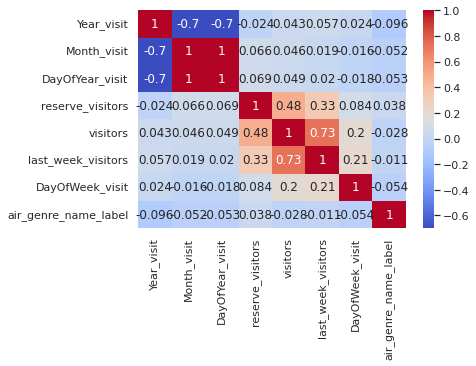

In [464]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

# 学習データ用意

In [465]:
#トレーニングデータ・検証用・テストデータの分割
# 説明変数,目的変数
X = dataset.drop('visitors',axis=1) # 説明変数
y = dataset['visitors'] # 目的変数(来店数)

feature_names = dataset.drop('visitors',axis=1).columns.tolist()
print(feature_names)

['Year_visit', 'Month_visit', 'DayOfYear_visit', 'reserve_visitors', 'last_week_visitors', 'DayOfWeek_visit', 'air_genre_name_label']


In [466]:
print(X)

      Year_visit  Month_visit  DayOfYear_visit  reserve_visitors  \
0           2016           10              305                 2   
1           2016           10              305                 4   
2           2016           10              305                 6   
3           2016           10              305                 7   
4           2016           10              305                 7   
...          ...          ...              ...               ...   
8047        2016            1                2                 4   
8048        2017            1                1                12   
8049        2016            7              196                 2   
8050        2016            7              197                 6   
8051        2016            7              199                 2   

      last_week_visitors  DayOfWeek_visit  air_genre_name_label  
0                    1.0                0                     6  
1                   17.0                0          

In [467]:
print(y)

0       26
1       16
2       11
3       11
4       12
        ..
8047    12
8048    12
8049    20
8050    14
8051    47
Name: visitors, Length: 8052, dtype: int64


In [468]:
#デフォルトはtest_size=0.25で25%がテスト用、残りの75%が訓練用となる。
#デフォルトでは要素がシャッフルされて分割される。
#シャッフルされる場合、デフォルトでは実行するたびにランダムに分割される。引数random_stateを指定して乱数シードを固定すると常に同じように分割される。
#機械学習のモデルの性能を比較するような場合、どのように分割されるかによって結果が異なってしまうため、乱数シードを固定して常に同じように分割されるようにする必要がある。

X_train_, X_test, y_train_, y_test = train_test_split(X, y,test_size=0.20, random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_,test_size=0.10, random_state=2)

X_train

,Year_visit,Month_visit,DayOfYear_visit,reserve_visitors,last_week_visitors,DayOfWeek_visit,air_genre_name_label
3522,2016,2,49,8,NaN,3,7
5045,2016,3,89,22,32.0,1,11
3232,2017,3,90,36,75.0,4,6
1099,2016,12,337,6,4.0,4,6
329,2017,3,60,5,35.0,2,10
...,...,...,...,...,...,...,...
5730,2017,1,21,12,NaN,5,8
7587,2016,1,30,20,31.0,5,11
3502,2016,2,43,42,54.0,4,11
5917,2017,2,47,9,18.0,3,7


# 学習

In [469]:
regressor = xgb.XGBRegressor(max_depth=10,n_estimators=150)
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [470]:
#regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)])
regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-rmse:22.97750	validation_1-rmse:22.23487
[1]	validation_0-rmse:17.67462	validation_1-rmse:17.48150
[2]	validation_0-rmse:14.05087	validation_1-rmse:14.48799
[3]	validation_0-rmse:11.67191	validation_1-rmse:12.76543
[4]	validation_0-rmse:10.04974	validation_1-rmse:11.75139
[5]	validation_0-rmse:8.96682	validation_1-rmse:11.14223
[6]	validation_0-rmse:8.21091	validation_1-rmse:10.82700
[7]	validation_0-rmse:7.67175	validation_1-rmse:10.64401
[8]	validation_0-rmse:7.30757	validation_1-rmse:10.58311
[9]	validation_0-rmse:6.90462	validation_1-rmse:10.57571
[10]	validation_0-rmse:6.59804	validation_1-rmse:10.58605
[11]	validation_0-rmse:6.37678	validation_1-rmse:10.61202
[12]	validation_0-rmse:6.24048	validation_1-rmse:10.57444
[13]	validation_0-rmse:6.10182	validation_1-rmse:10.56400
[14]	validation_0-rmse:5.94162	validation_1-rmse:10.54263
[15]	validation_0-rmse:5.80528	validation_1-rmse:10.57802
[16]	validation_0-rmse:5.70039	validation_1-rmse:10.59624
[17]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [471]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))
print(training_rounds)

range(0, 150)


# モデル品質チェック：バイアスと分散(overfitting or underfitting)

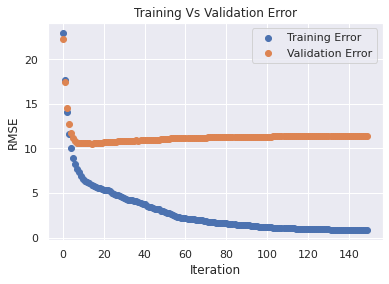

In [472]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

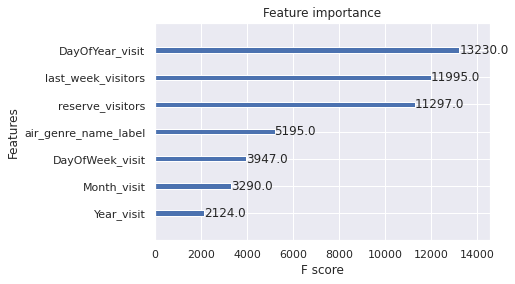

In [473]:
xgb.plot_importance(regressor)
plt.show()

# モデル改良

過学習していることが分かったので、下記の候補のうち、
「早期打ち切り」等を適用

-データ数を増やす

-単純なモデルにする

-正規化する(L1, L2)

-交差検証法を用いる

-学習の早期打ち切り

-むやみに説明変数を増やさない(特徴量選択、次元圧縮)

また、需要予測のため、需要が足りない方に予測しては業務影響があるため、
評価指標をRMSLEとしてみる

In [475]:
# max_depthを小さく
# alpha(L1正則化項)をきかせる
boost_params = {'eval_metric': 'rmsle'}

regressor = xgb.XGBRegressor(max_depth=8,n_estimators=150,alpha = 10, learning_rate=0.05,**boost_params)
regressor

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)

In [476]:
regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],early_stopping_rounds = 5)


[0]	validation_0-rmsle:2.12506	validation_1-rmsle:2.11307
[1]	validation_0-rmsle:1.79773	validation_1-rmsle:1.79231
[2]	validation_0-rmsle:1.57053	validation_1-rmsle:1.56803
[3]	validation_0-rmsle:1.39864	validation_1-rmsle:1.40024
[4]	validation_0-rmsle:1.26133	validation_1-rmsle:1.26639
[5]	validation_0-rmsle:1.14941	validation_1-rmsle:1.15602
[6]	validation_0-rmsle:1.05517	validation_1-rmsle:1.06331
[7]	validation_0-rmsle:0.97557	validation_1-rmsle:0.98603
[8]	validation_0-rmsle:0.90676	validation_1-rmsle:0.91860
[9]	validation_0-rmsle:0.84717	validation_1-rmsle:0.85758
[10]	validation_0-rmsle:0.79523	validation_1-rmsle:0.80756
[11]	validation_0-rmsle:0.74978	validation_1-rmsle:0.76443
[12]	validation_0-rmsle:0.70996	validation_1-rmsle:0.72639
[13]	validation_0-rmsle:0.67484	validation_1-rmsle:0.69389
[14]	validation_0-rmsle:0.64396	validation_1-rmsle:0.66415
[15]	validation_0-rmsle:0.61662	validation_1-rmsle:0.63869
[16]	validation_0-rmsle:0.59244	validation_1-rmsle:0.61699
[17]	va

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

In [477]:
eval_result = regressor.evals_result()
#training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds = range(len(eval_result['validation_0']['rmsle']))
print(training_rounds)

range(0, 48)


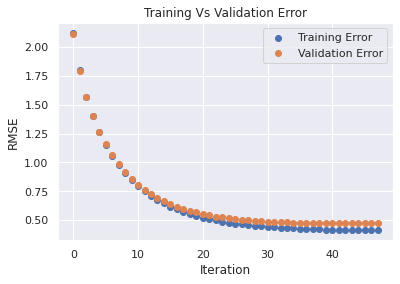

In [478]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmsle'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmsle'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [479]:
y_test

659      9
291     22
495     17
1854    10
7297    33
        ..
2992    47
341     14
6786    15
5370    44
7204    17
Name: visitors, Length: 1611, dtype: int64

In [480]:
df = pd.DataFrame(y_test)
df

,visitors
659,9
291,22
495,17
1854,10
7297,33
...,...
2992,47
341,14
6786,15
5370,44


In [481]:
result = regressor.predict(X_test)
result[:5]

array([ 8.220337, 16.608568, 11.71429 , 10.913137, 31.56921 ],
      dtype=float32)

In [482]:
df['predicted_visitors'] = result
df.head()

,visitors,predicted_visitors
659,9,8.220337
291,22,16.608568
495,17,11.714290
1854,10,10.913137
7297,33,31.569210


# モデル品質チェック：値妥当性

In [483]:
df['predicted_visitors'].describe()

count    1611.000000
mean       21.554789
std        12.425283
min         5.262541
25%        11.929323
50%        18.049038
75%        28.811297
max       109.666077
Name: predicted_visitors, dtype: float64

visiterは0以上であればよいので、値妥当性は問題なし

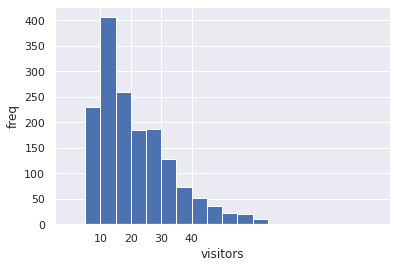

In [484]:
data = df['predicted_visitors'].tolist()
plt.xlabel('visitors')
plt.ylabel('freq')
plt.xticks([10,20,30,40,]) 
plt.hist(data, range=(0, 100), bins=20);

# モデル品質チェック：残差確認

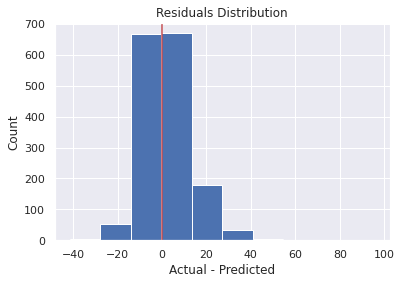

In [485]:
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = (df['visitors'] - df['predicted_visitors'])

plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [486]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:0.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:0.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.53
 Over  Estimation: 0.47


※改善検討
RMSLEで下振れを減らしたつもりだが、まだ下振れのケースが半数近くあるため、
工夫して下振れを減らす必要がある

In [487]:
def compute_rmsle(y_true, y_pred):
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
        
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
     
    return(np.average((np.log1p(y_pred) - np.log1p(y_true))**2)**.5)


print('RMSLE')
print(compute_rmsle(df['visitors'],df['predicted_visitors']))

RMSLE
0.4694120023890783


学習時との差がないため、汎化性能は悪くない

In [488]:
print("RMSE: {0:0.2f}".format(np.sqrt(mean_squared_error(df['visitors'],df['predicted_visitors']))))


RMSE: 10.75


ただ、RMSEが10人と低くないため、under fittingしている傾向がある(=の特徴量とターゲット変数の関係を正確に把握できるほど十分に複雑でない)ようなので、
今後は複雑度を上げるように下記の改善検討が必要だと考える



> 関連変数の追加、combine feature、Train longer (more iterations)、正規化を減らす etc


# 天気情報を追加した場合

In [489]:
#重複、不要カラムの削除
dataset = df_target_ar_as_av_wf.drop(
    ["air_area_name_x","latitude_x","longitude_x","latitude_str","longitude_str","station_id","station_latitude","station_longitude","station_vincenty","station_great_circle","air_genre_name_y","air_area_name_y","latitude_y","longitude_y","air_store_id","target_date_x","air_genre_name_x","deepest_snowfall","total_snowfall","DayOfWeek_visit_x","target_date_y","DayOfWeek_visit_y","precipitation","deepest_snowfall","total_snowfall"],axis=1)
display(dataset)

,Year_visit,Month_visit,DayOfYear_visit,reserve_visitors,avg_temperature,high_temperature,low_temperature,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,visitors,last_week_visitors,DayOfWeek_visit,air_genre_name_label
0,2016,10,305,2,14.3,19.1,9.8,3.9,9.79,1.8,11.0,1021.2,68.0,1024.1,9.0,26,1.0,0,6
1,2016,10,305,4,14.3,19.1,9.8,3.9,9.79,1.8,11.0,1021.2,68.0,1024.1,9.0,16,17.0,0,10
2,2016,10,305,6,14.3,19.1,9.8,3.9,9.79,1.8,11.0,1021.2,68.0,1024.1,9.0,11,13.0,0,7
3,2016,10,305,7,14.3,19.1,9.8,3.9,9.79,1.8,11.0,1021.2,68.0,1024.1,9.0,11,NaN,0,6
4,2016,10,305,7,14.3,19.1,9.8,3.9,9.79,1.8,11.0,1021.2,68.0,1024.1,9.0,12,NaN,0,10


In [491]:
print(dataset.dtypes)

Year_visit                int64
Month_visit               int64
DayOfYear_visit           int64
reserve_visitors          int64
avg_temperature         float64
high_temperature        float64
low_temperature         float64
hours_sunlight          float64
solar_radiation         float64
avg_wind_speed          float64
avg_vapor_pressure      float64
avg_local_pressure      float64
avg_humidity            float64
avg_sea_pressure        float64
cloud_cover             float64
visitors                  int64
last_week_visitors      float64
DayOfWeek_visit           int64
air_genre_name_label      int64
dtype: object


In [492]:
X = dataset.drop('visitors',axis=1) # 説明変数
y = dataset['visitors'] # 目的変数(来店数)

feature_names = dataset.drop('visitors',axis=1).columns.tolist()
print(feature_names)

['Year_visit', 'Month_visit', 'DayOfYear_visit', 'reserve_visitors', 'avg_temperature', 'high_temperature', 'low_temperature', 'hours_sunlight', 'solar_radiation', 'avg_wind_speed', 'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity', 'avg_sea_pressure', 'cloud_cover', 'last_week_visitors', 'DayOfWeek_visit', 'air_genre_name_label']


In [493]:
X_train_, X_test, y_train_, y_test = train_test_split(X, y,test_size=0.20, random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_,test_size=0.10, random_state=2)

X_train

,Year_visit,Month_visit,DayOfYear_visit,reserve_visitors,avg_temperature,high_temperature,low_temperature,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,last_week_visitors,DayOfWeek_visit,air_genre_name_label
3522,2016,2,49,8,6.2,10.7,1.1,6.8,13.09,2.6,5.2,1021.9,53.0,1024.9,4.8,NaN,3,7
5045,2016,3,89,22,13.0,18.6,7.4,9.8,21.35,3.3,8.2,1019.8,57.0,1022.8,5.0,32.0,1,11
3232,2017,3,90,36,8.8,12.3,4.9,0.7,5.19,3.0,6.7,1014.3,62.0,1017.3,9.0,75.0,4,6
1099,2016,12,337,6,11.5,15.5,8.7,8.5,11.70,2.9,6.6,1017.8,49.0,1020.8,4.5,4.0,4,6
329,2017,3,60,5,6.4,11.1,1.4,5.6,12.42,1.8,6.9,1018.6,73.0,1021.6,6.5,35.0,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,2017,1,21,12,5.9,11.0,1.2,9.4,13.33,3.9,4.7,1011.9,52.0,1014.9,3.5,NaN,5,8
7587,2016,1,30,20,3.3,5.0,1.5,0.0,3.17,2.3,6.7,1017.2,87.0,1020.3,10.0,31.0,5,11
3502,2016,2,43,42,7.2,11.9,1.5,2.4,8.68,2.1,6.7,1028.1,64.0,1031.1,7.5,54.0,4,11
5917,2017,2,47,9,7.3,13.7,1.3,9.9,16.29,2.2,5.7,1020.8,55.0,1023.8,2.3,18.0,3,7


In [421]:
#boost_params = {'eval_metric': 'rmsle'}

#regressor = xgb.XGBRegressor(max_depth=8,n_estimators=150,alpha = 10, learning_rate=0.05,**boost_params)
#regressor

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)

In [494]:
regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],early_stopping_rounds = 5)


[0]	validation_0-rmsle:2.12601	validation_1-rmsle:2.11694
[1]	validation_0-rmsle:1.79908	validation_1-rmsle:1.79574
[2]	validation_0-rmsle:1.57117	validation_1-rmsle:1.57110
[3]	validation_0-rmsle:1.39908	validation_1-rmsle:1.40373
[4]	validation_0-rmsle:1.26098	validation_1-rmsle:1.26961
[5]	validation_0-rmsle:1.14856	validation_1-rmsle:1.15956
[6]	validation_0-rmsle:1.05374	validation_1-rmsle:1.06770
[7]	validation_0-rmsle:0.97354	validation_1-rmsle:0.99034
[8]	validation_0-rmsle:0.90427	validation_1-rmsle:0.92494
[9]	validation_0-rmsle:0.84404	validation_1-rmsle:0.86415
[10]	validation_0-rmsle:0.79153	validation_1-rmsle:0.81451
[11]	validation_0-rmsle:0.74573	validation_1-rmsle:0.77136
[12]	validation_0-rmsle:0.70500	validation_1-rmsle:0.73461
[13]	validation_0-rmsle:0.66927	validation_1-rmsle:0.70145
[14]	validation_0-rmsle:0.63793	validation_1-rmsle:0.67305
[15]	validation_0-rmsle:0.61037	validation_1-rmsle:0.64825
[16]	validation_0-rmsle:0.58583	validation_1-rmsle:0.62653
[17]	va

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

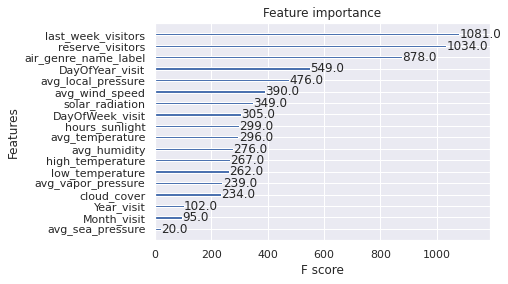

In [495]:
xgb.plot_importance(regressor)
plt.show()

In [496]:
eval_result = regressor.evals_result()
#training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds = range(len(eval_result['validation_0']['rmsle']))
print(training_rounds)

range(0, 56)


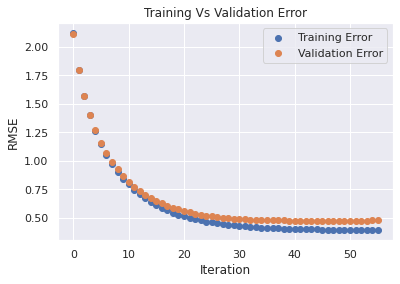

In [497]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmsle'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmsle'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [498]:
result = regressor.predict(X_test)
result[:5]

array([ 9.002754, 15.042151, 12.729805, 11.475645, 35.854847],
      dtype=float32)

In [499]:
df = pd.DataFrame(y_test)
df['predicted_visitors'] = result
df.head()


,visitors,predicted_visitors
659,9,9.002754
291,22,15.042151
495,17,12.729805
1854,10,11.475645
7297,33,35.854847


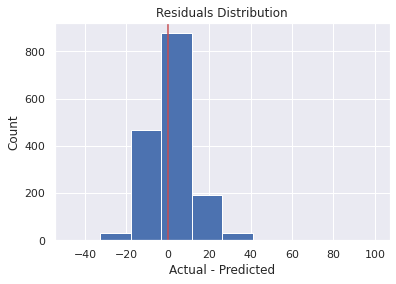

In [500]:
residuals = (df['visitors'] - df['predicted_visitors'])

plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [501]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:0.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:0.2f}'.format(value_counts[False]/len(residuals)))


 Under Estimation: 0.49
 Over  Estimation: 0.51


In [502]:
print('RMSLE')
print(compute_rmsle(df['visitors'],df['predicted_visitors']))


RMSLE
0.47600293240834285


In [503]:
print("RMSE: {0:0.2f}".format(np.sqrt(mean_squared_error(df['visitors'],df['predicted_visitors']))))


RMSE: 10.67
